In [38]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from IPython.display import display
import h5py
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

In [41]:
batch_size = 5000
num_classes = 10
epochs = 1

In [42]:
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("X_train original shape", x_train.shape)
print("y_train original shape", y_train.shape)

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print('x_train shape (after adding channels):', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

('X_train original shape', (60000, 28, 28))
('y_train original shape', (60000,))
('x_train shape (after adding channels):', (60000, 28, 28, 1))
(60000, 'train samples')
(10000, 'test samples')


In [43]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), strides=(1,1), input_shape=input_shape, name='Input_Conv2D_1', activation='relu'))
model.add(BatchNormalization(axis=-1, name='BatchNorm_1'))

model.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1), activation='relu', name='Conv2D_2'))
model.add(BatchNormalization(axis=-1, name='BatchNorm_2'))
model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPool_2'))
model.add(Dropout(0.25, name='Dropout_2'))

model.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1), name='Conv2D_3', activation='relu'))
model.add(BatchNormalization(axis=-1, name='BatchNorm_3'))
model.add(MaxPooling2D(pool_size=(2,2), name='MaxPool_3'))

model.add(Flatten(name='Flatten')) # Fully connected layer
model.add(BatchNormalization(name='BatchNorm_Flatten'))

model.add(Dense(128, name='Dense_5', activation='relu'))
model.add(BatchNormalization(name='BatchNorm_5'))
model.add(Dropout(0.5, name='Dropout_5'))

model.add(Dense(num_classes, activation='softmax', name='SoftMax_Output'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Conv2D_1 (Conv2D)      (None, 26, 26, 32)        320       
_________________________________________________________________
BatchNorm_1 (BatchNormalizat (None, 26, 26, 32)        128       
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
BatchNorm_2 (BatchNormalizat (None, 24, 24, 64)        256       
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 12, 12, 64)        0         
_________________________________________________________________
Dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 10, 10, 64)        36928     
__________

In [44]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, y_train,batch_size=batch_size, epochs=1,
           validation_split=0.1, verbose=1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 874s 16ms/step - loss: 0.9740 - acc: 0.7135 - val_loss: 0.1636 - val_acc: 0.9492


In [45]:
model.save("mnist_cnn.h5", overwrite=True)

In [46]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [47]:
img = x_test[1]

In [48]:
import numpy as np

In [49]:
img = np.expand_dims(img, axis=0)

In [50]:
img.shape

(1, 28, 28, 1)

In [51]:
activations = activation_model.predict(img)

In [52]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 26, 26, 32)


# Visualization of a layer

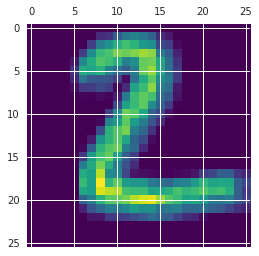

In [53]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

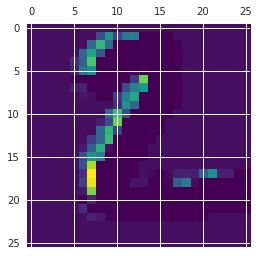

In [54]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

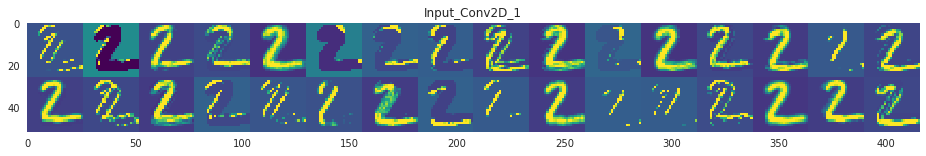

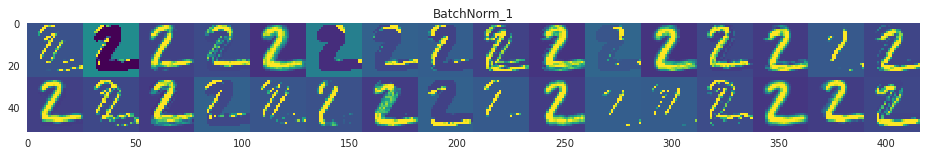

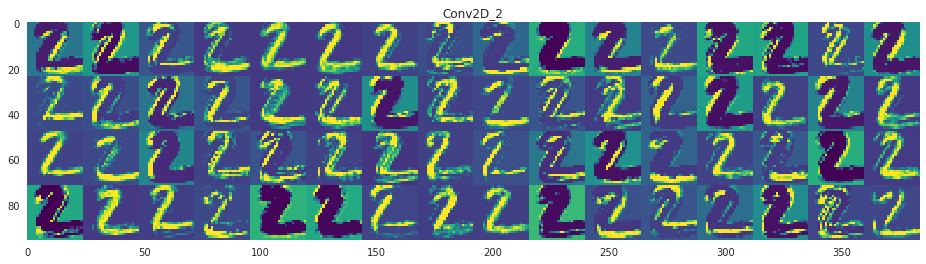

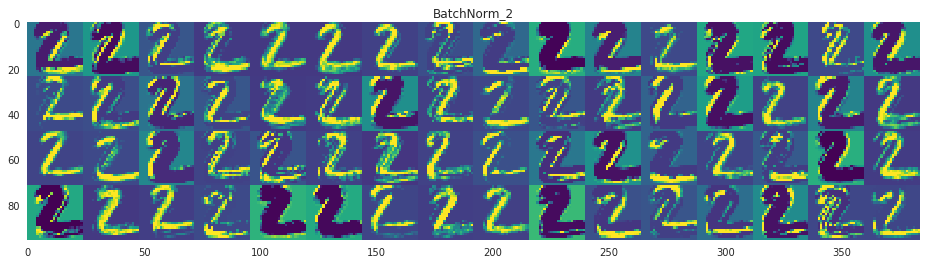

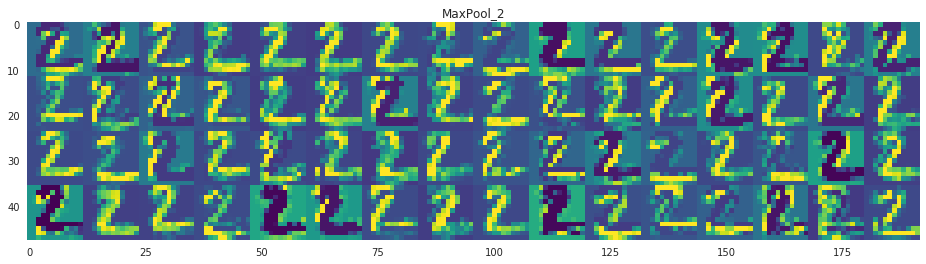

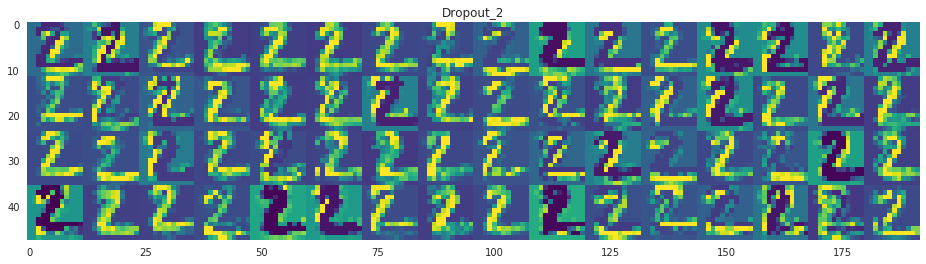

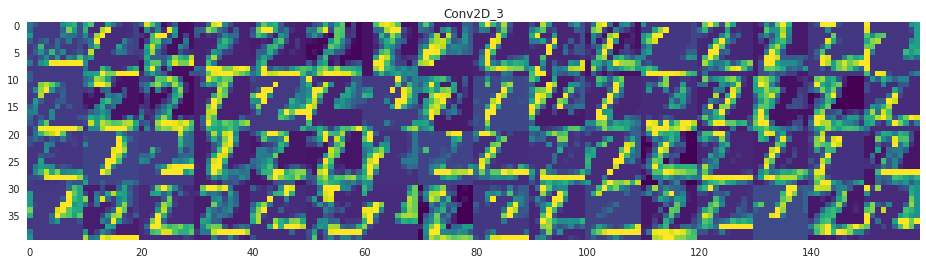

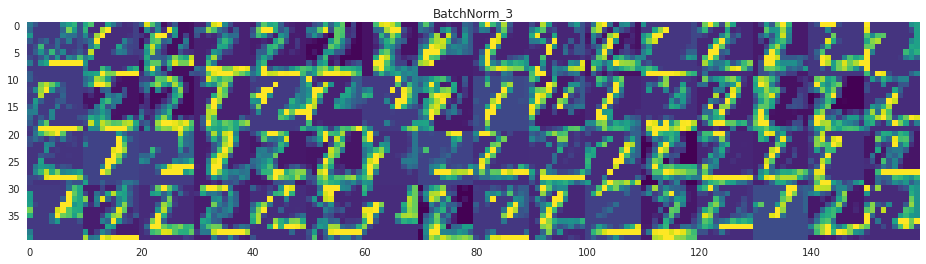

In [55]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [75]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [76]:
grads = K.gradients(loss, model.input)[0]

In [77]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [78]:
iterate = K.function([model.input], [loss, grads])
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [79]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1. 
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [80]:
def deprocess_image(x):
    x -= np.amin(x)
    x /= np.amax(x)
    # convert to RGB array
    x *= 255
    x = x.astype('uint8')
    return x

In [81]:
def generate_pattern(layer_name, filter_index, size=150):
   
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]

    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

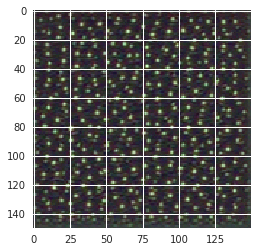

In [82]:
from matplotlib import pyplot as plt
plt.imshow(generate_pattern('block3_conv1', 0))

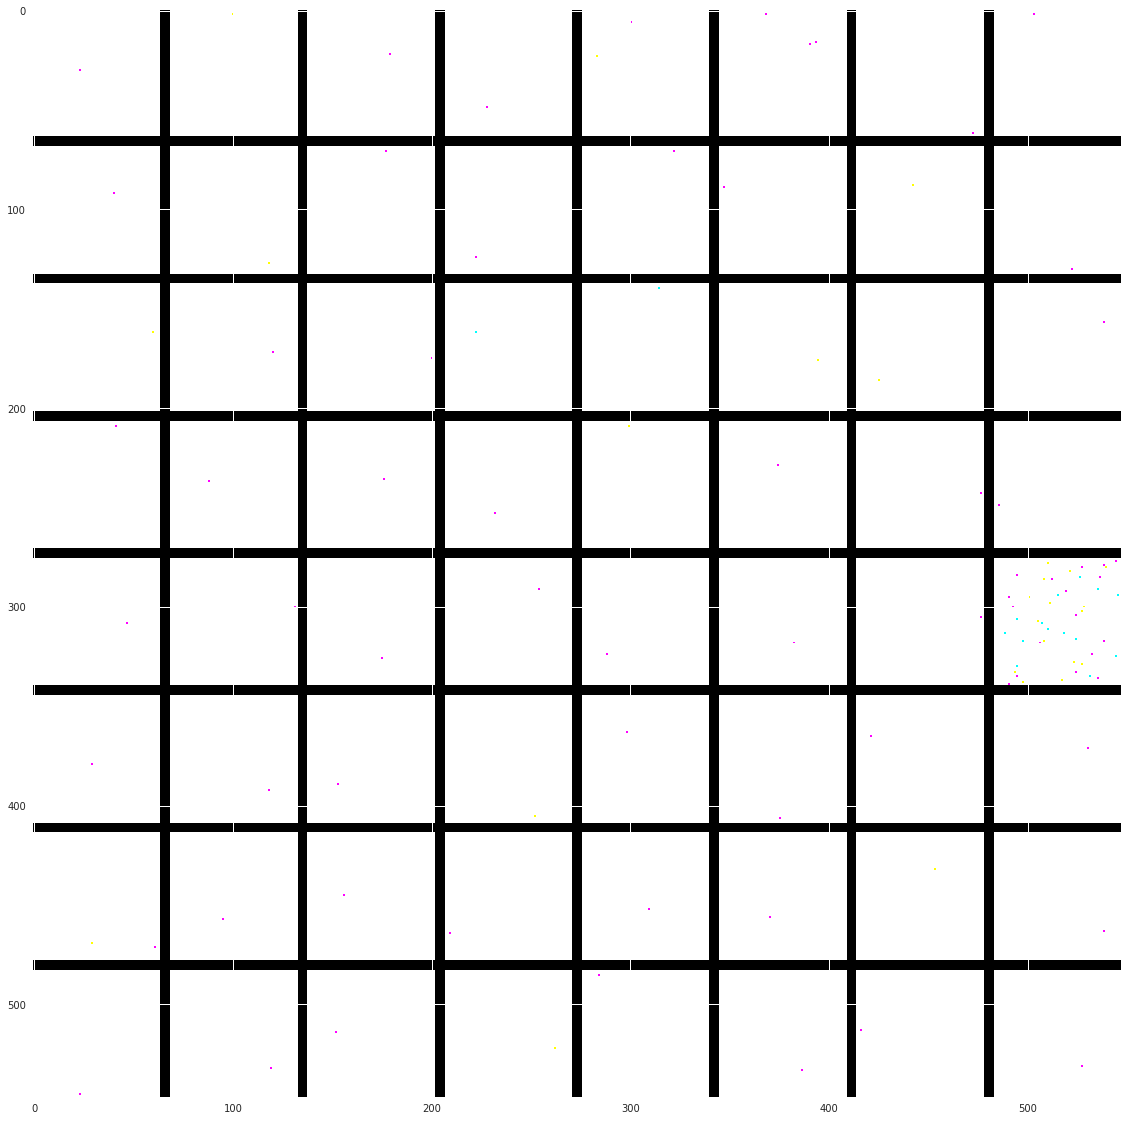

In [85]:
layer_name = 'block4_conv1'
size = 64
margin = 5

    # This a empty (black) image where we will store our results.
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):  # iterate over the rows of our results grid
    for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
plt.figure(figsize=(20, 20))
plt.imshow(results)
plt.show()

# Visualizing GRADCAM

In [86]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

In [87]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
img_path = 'elephants2.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [88]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

('Predicted:', [(u'n02504458', u'African_elephant', 0.45042375), (u'n01871265', u'tusker', 0.34552908), (u'n02504013', u'Indian_elephant', 0.20404677)])


In [89]:
np.argmax(preds[0])

386

In [90]:
african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')

In [91]:
from keras import backend as K
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)

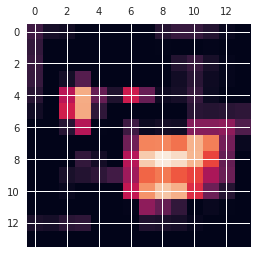

In [92]:
import matplotlib.pyplot as plt
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)


In [93]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('elephant_cam.jpg', superimposed_img)

True

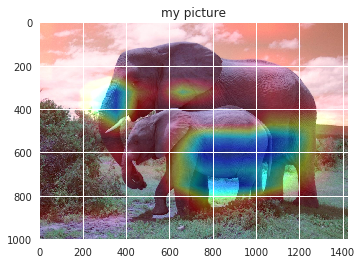

In [94]:
from matplotlib import pyplot as plt
import cv2

img = cv2.imread('elephant_cam.jpg')

plt.imshow(img)
plt.title('my picture')
plt.show()